In [13]:
#import sys,os

# !apt-get remove python-casacore -y

# !conda install -c conda-forge python-casacore -y

#1375091767.full_pol.ms/

#!ls -l /data/KAT7_data/aoflagged/flagged/1375091767.full_pol.ms

In [56]:
from casacore.tables import table
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import precision_recall as preval

import sklearn.metrics as metrics
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

import pandas as pd

%matplotlib inline

### Define path to MS file

In [57]:
# pre-flagged MS file
#/data/KAT7_data/aoflagged/flagged/1375091767.full_pol.ms
#MSfile = '1375091767.full_pol_av.ms'
basename="1375091767.full_pol.ms"
MSfile = '/data/KAT7_data/KAT7_data/original/'+basename   #
MSfileFlagged = '/data/KAT7_data/aoflagged/flagged/'+basename

basename_av='1354773022.full_pol_av.ms'
MSfile_av = '/data/KAT7_data/KAT7_data/original/'+basename
MSfileFlagged_av = '/data/KAT7_data/aoflagged/flagged/'+basename_av

In [58]:
#%%writefile precision_recall.py

def get_nestlist(arr, i, j, rho=1,value=False):
    """Return d-th neighbors of cell (i, j)"""

    if arr.ndim != 2:
        raise ValueError("need 2-D input")    
        
    def get_nbr_list(d):
        if d==0:
            dth_nbr_list=[(i,j)]
        else:
            #----- left side -----
            ilc = np.clip(i - d, 0, arr.shape[0]-1)
            jlc = j
            #
            ilu = ilc
            jlu = np.clip(j + d, 0, arr.shape[1]-1)
            #
            ild = ilc
            jld = np.clip(j - d, 0, arr.shape[1]-1)
            #----- right side ----
            irc = np.clip(i + d, 0, arr.shape[0]-1)
            jrc = j
            #
            iru = irc
            jru = np.clip(j + d, 0, arr.shape[1]-1)
            #
            ird = irc
            jrd = np.clip(j - d, 0, arr.shape[1]-1)
            #----- top and bottom ---
            it = i
            jt = np.clip(j + d, 0, arr.shape[1]-1)
            #
            ib = i
            jb = np.clip(j - d, 0, arr.shape[1]-1)

            dth_nbr_list = [(it,jt),(ib,jb), 
                    (ird,jrd), (irc,jrc), (iru,jru),
                    (ild,jld), (ilc,jlc), (ilu,jlu)]
        return dth_nbr_list
    
    #get neighbour list
    nbr_list = []
    for d in range(0,rho+1):
        nbr_list.extend(get_nbr_list(d))

    #order of output is random for now
    if not value:
        return nbr_list
    else:
        return np.array([ arr[ix] for ix in nbr_list ])
    

def findIntersection(fun1,fun2,x0):
    return fsolve(lambda x : fun1(x) - fun2(x),x0)            
    
class roc_eval(object):
    
    def __init__(self,gt_list,pred_list,
                 rho=0,threshold=None,
                background=None,obj=None,
                 verbose=0, plot=False, 
                 diagline=True):
        
        self.gt_list = gt_list
        self.pred_list = pred_list
        self.rho = rho
        self.threshold = threshold 
        self.background = background, 
        self.obj = obj
        self.verbose = verbose
        self.plot_diagline = diagline
        
        self.stat = self.precision_recall(gt_list, pred_list,threshold=threshold)
        
        if plot:
            self.plot_roc_curve(data=self.stat['ax_data'])
            
    def precision(self,x=None): 
        #return self.stat.
        if x is None:
            x = self.threshold
        return self.fvalue('precision')(x)
    
    def recall(self,x=None): 
        #return self.stat.
        if x is None:
            x = self.threshold
        return self.fvalue('recall')(x)
    
    def fp(self,x=None): 
        #return self.stat.
        if x is None:
            x = self.threshold
        return self.fvalue('FP')(x)
    
    def fn(self,x=None): 
        #return self.stat.
        if x is None:
            x = self.threshold
        return self.fvalue('FN')(x)
    
    def f1_score(self,x=None):
        p = self.precision(x)
        r = self.recall(x)
        return 2 * (p * r) / (p + r) 
    
    def auc(self,name='pr'):
        f1,f2 = self.get_stat(name=name, value=True)
        return metrics.auc(f1,f2)
    
    def break_even_point(self,name='pr'):
        x = np.linspace(0,1,1000)
        f1,f2 = self.get_stat(x=x,name=name,value=True)
        f=f1-f2
        zero_crossings = np.where(np.diff(np.sign(f)))[0]
        return np.mean([ f1[zero_crossings[0]],f1[zero_crossings[0]] ])
    
    def get_stat(self, x=None, value=True,name='pr'):
        
        if name=='pr':
            f1=self.fvalue('recall')
            f2=self.fvalue('precision')
        elif name=='roc':
            f1=self.fvalue('FP')
            f2=self.fvalue('FN')    
        else:
            if isinstance(name,(list,tuple)):
                f1=self.fvalue(name[0])
                f2=self.fvalue(name[1])            
            else:
                print('Error: name is unknown!')
                return None, None
            
        #return value or interp func
        if value:
            if x is None:
                x = self.threshold            
            return f1(x), f2(x)
        else:
            return f1, f2
    
    def match_relaxed(self,pixvec,arr,cond='FP'):
        arr_out=[]
        for i in np.ndindex(pixvec.shape):
            if pixvec[i]:            
                pix_list = get_nestlist(arr, i[0], i[1], rho=self.rho,value=True)
                #print(i, pixvec[i], arr[i], cond in pix_list)
                if cond=='FN':
                    arr_out.append( max(pix_list) )
                else:
                    arr_out.append( min(pix_list) )

        return np.array(arr_out)

    def fp_fn_pfnum(self, gtBin, cur_prob, thres):

        assert len(cur_prob.shape) == 2, 'Wrong size of input prob map s'
        assert len(gtBin.shape) == 2, 'Wrong size of input prob map'
        thresInf = np.concatenate(([-100], thres, [100]))

        #print('computing FP, TP, FN, TN thresInf:',thresInf)
        posNum = np.sum(gtBin == True)
        negNum = np.sum(gtBin == False)
        print('totP, totN',posNum,negNum)
        
        # histogram of false negatives  
        pixvec = (gtBin == True)        
        #fnArray = self.match_relaxed(pixvec,cur_prob,cond='FN') 
        fnArray = cur_prob[pixvec]
        
        fnHist = np.histogram(fnArray,bins=thresInf)[0]
        fnCum = np.cumsum(fnHist)
        FN = fnCum[0:0+len(thres)];
        #print('fnHist, fnCum, FN:',fnHist,fnCum, FN)
        
        #FIXEME: how to compute relaxed FPs?
        pixvec = (gtBin == False)
        #fpArray = self.match_relaxed(pixvec,cur_prob,cond='FP') 
        fpArray = cur_prob[pixvec]
        
        fpHist,bin_edge  = np.histogram(fpArray, bins=thresInf)    
        fpCum = np.flipud(np.cumsum(np.flipud(fpHist)))
        FP = fpCum[1:1+len(thres)]
        #print('fpHist, fpCum, FP:',fpHist,fpCum, FP)
            
        return FN, FP, posNum, negNum

    def fnfp_to_pr(self, total_fn, total_fp, 
                   total_posnum, total_negnum):

        #calculate precision and recall
        total_tp = total_posnum - total_fn
        total_tn = total_negnum - total_fp
        #print('total_tp, total_tn: ',total_tp, total_tn)
        #
        TP=total_tp 
        TN=total_tn
        FN=total_fn
        FP=total_fp
        P = TP + FN
        N = TN + FP
        TPR = TP / P
        FPR = FP / N

        recall = total_tp / float( total_posnum )
        precision = total_tp / (total_tp + total_fp + 1e-10)
        
        
        #print('total_tp',total_tp)
        #print('recall',recall)
        #print('precision',precision)

        eval_dict = {'recall': recall,
                    'precision': precision,
                    'TPR_wp':TPR,
                    'FPR_wp':FPR,
                    'TP':TP,'TN':TN,
                    'FP':FP,'FN':FN,
                    'ax_data':[{'x':[FPR,'False Positive Rate'],
                                'y':[TPR,'True Positive Rate'],
                                'title':'ROC Curve'},
                              {'x':[recall,'Recall'], 
                               'y':[precision,'Precision'],
                               'title':'Precision-Recall Curve'}]                 
                    }
        

        return eval_dict

    def fvalue(self,name,k='cubic'):
        return interp1d(self.threshold, self.stat[name], 
                        fill_value='extrapolate') #kind=k, 
    
    def precision_recall(self, gt_list=None, 
                         pred_list=None,threshold=None, 
                         verbose=None):
        """."""

        if not verbose is None: 
            self.verbose = verbose
            
        if gt_list is None: 
            gt_list = self.gt_list
            
        if pred_list is None: 
            pred_list = self.pred_list
            
        if not isinstance(gt_list,list):
            gt_list = [gt_list]

        if not isinstance(pred_list,list):
            pred_list = [pred_list]

        gt_dtype = gt_list[0].dtype
        pred_dtype = pred_list[0].dtype

        if pred_dtype==np.float:
            tvec = np.array(range(0, 255))/255.0
        else:
            tvec = [0.5]

        if threshold is None:
            self.threshold = np.array(tvec)
        else:
            self.threshold = np.array(threshold)
            
        #
        threshold = self.threshold
        
        #
        if self.verbose>0:
            print('threshold.shape: ',threshold.shape)
            print('gt_dtype,pred_dtype',gt_dtype,pred_dtype)


        total_fp = np.zeros(threshold.shape)
        total_fn = np.zeros(threshold.shape)
        total_posnum = 0
        total_negnum = 0

        for gt, pred in zip(gt_list, pred_list):
            #    
            FN, FP, posNum, negNum = self.fp_fn_pfnum(gt, pred, threshold)
            #
            if self.verbose>0:
                print('FN, FP, posNum, negNum:',FN, FP, posNum, negNum)
            #
            total_fp += FP
            total_fn += FN
            total_posnum += posNum
            total_negnum += negNum  

        return self.fnfp_to_pr(total_fn, total_fp, total_posnum, total_negnum)

    def plot_roc_ax(self, data, ax=None, drawCol=1, 
                        textLabel = None, title = None, fontsize1 = 24, 
                        fontsize2 = 20, linewidth = 3):

        if ax is None:
            fig, ax = plt.subplots()

        #tableString = 'Algo avgprec Fmax prec recall accuracy fpr Q(TonITS)\n'
        linecol = ['g','m','b','c']
        linesty = ['-','--','-','--']


        if len(data['x'][0])==1: 
            ax.plot(data['x'][0], data['y'][0],'*', markersize=10,
                         label = textLabel, color='k') 
        else:
            if data['x'][1].lower()=='recall':
                data['x'][0]=np.append(data['x'][0],0)
                data['y'][0]=np.append(data['y'][0],1)

            if textLabel is None: textLabel=''
            auc=metrics.auc(data['x'][0], data['y'][0]) 
            #
            if data['x'][1].lower()=='recall':
                print('Precision-Recall AUC: ',auc)
            else:
                print('ROC AUC: ',auc)

            if textLabel:
                textLabel="%s (AUC=%.2f)"%(textLabel, auc)
            else:
                textLabel="AUC=%.2f"%(auc)

            ax.plot(data['x'][0], data['y'][0], linewidth=linewidth, 
                 color=linecol[drawCol], label=textLabel,ls=linesty[drawCol])
        
        
        #draw diagonal line
        if self.plot_diagline:
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            x = np.linspace(xlim[0],xlim[1],100)
            y = np.linspace(ylim[0],ylim[1],100)
            if data['x'][1].lower()=='recall':
                ax.plot(x,y,lw='0.5',color='k')
            else:
                ax.plot(np.flipud(x),y,lw='0.5',color='k')
            
        if textLabel:
            if data['x'][1].lower()=='recall':
                ax.legend(loc='lower left',prop={'size':fontsize2})
            else:
                ax.legend(loc='lower right',prop={'size':fontsize2})

        ax.set_title(data['title'], fontsize=fontsize1)

        #plt.title(title,fontsize=24)
        ax.set_ylabel(data['y'][1],fontsize=fontsize1)
        ax.set_xlabel(data['x'][1],fontsize=fontsize1)

        ax.grid(True)

    def plot_roc_curve(self, data=None,fout=None):

        if not data is None:
            if not isinstance(data, dict):
                stat_dict = {'':data}
            else:
                stat_dict = data
        else:
            stat_dict = {'':self.stat['ax_data']} 

        
        names = stat_dict.keys()

        fig, ax_list = plt.subplots(1,2,figsize=(15,5)) 

        icol=0
        for name, ax_data in stat_dict.iteritems():
            
            for d, ax in zip(ax_data, ax_list):
                
                self.plot_roc_ax(d, ax=ax,
                            fontsize1 = 16,
                            fontsize2 = 16, 
                            linewidth = 3, 
                            textLabel = name, 
                            drawCol=icol) 
            icol+=1
        #
        if not fout is None:
            plt.savefig( fout )    

### Some functions to easily investigate an MS file

In [59]:
class read_casa_table(object):
    
    def __init__(self,path_msfile,aoflag=False, verbose=1):
        
        self.verbose = verbose
        self.tbl = table(path_msfile)
        self.isaoflagged = aoflag
        
        self.a1_name="ANTENNA1"
        self.a2_name="ANTENNA2"
        
        #set antenna parameters
        _ = self.set_antenna_params()
        
    def set_antenna_params(self):
            
        A1, A2 = self.tbl.getcol(self.a1_name), self.tbl.getcol(self.a2_name)
        
        # get the list of antennas for each entry in the main table
        ant_list=list(set(np.append(A1,A2)))

        # get the scan numbers for each entry in the main tables
        #scans = t.getcol("SCAN_NUMBER")

        nants = len(ant_list)

        ant1_map = []
        ant2_map = []
        for a1 in ant_list:
            for a2 in ant_list[a1+1:]:
                ant1_map.append(a1)
                ant2_map.append(a2)

        nbase = nants*(nants-1)/2
        
        if self.verbose>0:
            #print("Antenna Names: A1 = %s, A2=%s"%(self.a1_name, self.a2_name))
            print('Number of antennas:  ', nants)
            print('List of antennas:    ', ant_list)
            print('Number of baselines: ', nbase)
            print()
            
        self.nants, self.ant_list, self.nbase = (nants, ant_list, nbase)
        self.ant1_map, self.ant2_map = (ant1_map, ant2_map)
        self.A1, self.A2 = (A1, A2)
        
        
    def get_masked_data(self, ant1, ant2, poln=None, aoflag=None, verbose=None):
        if verbose is None:
            verbose=self.verbose
        
        if not aoflag is None:
            self.isaoflagged = aoflag
            
        # get flag column from main table 
        if self.isaoflagged:
            flags = self.tbl.getcol("FLAG_ROW")
        else:
            flags = self.tbl.getcol("FLAG")

        # get data column from main table
        data = self.tbl.getcol("DATA")

        # get the time column from the main table
        time = self.tbl.getcol("TIME")

        print('unmasked data.shape',data.shape)
        
        if verbose>0:
            #get other important stats
            print('Number of timestamps:    ', data.shape[0])        
            print('Number of channels:      ', data.shape[1])
            print('Number of polarisations: ', data.shape[2], '\n')  
            
        #using hand flagged mask
        index = (self.A1==ant1) & (self.A2==ant2)
        
        pol_list = np.arange(data.shape[-1])
        if not poln is None:
            pol_list = [poln]
        
        print('using pol_list=',pol_list)
        #
        data_list = {}
        masked_data_list = {}
        mean_amp = 0
        min_amp = np.inf
        for ipol in pol_list:
            data_pol = abs(data[index][:,:,ipol]) #data is complex
            flag_pol = np.array(flags[index][:,:,ipol])    
                
            masked_data_pol = np.ma.array(data_pol, mask=flag_pol)

            #get basic stats about data
            mean_amp = mean_amp + np.average(data_pol)/float(len(pol_list))
            min_amp = min([min_amp,np.min(data_pol)])
            
            #
            data_list[ipol] = data_pol.transpose()
            masked_data_list[ipol] = masked_data_pol.transpose()
        

        stat={'mean':mean_amp,"min":min_amp, 'pol_list':pol_list, 'time':time[index]}
        
        return data_list, masked_data_list, stat
    
    def get_uvw(self):
        # extract uvw  coordinates from the main table
        uvw = self.tbl.getcol("UVW")
        u,v,w = uvw[:,0],uvw[:,1],uvw[:,2]
        
    def plot_masked_data(self, ant1, ant2, arrout=False, 
                         tit='Flag', fout=None, **kwargs):
        #
        poln=None
        if 'poln' in kwargs.keys():
            poln=kwargs['poln']
        #
        data, masked_data, stat = self.get_masked_data(ant1, ant2, **kwargs)
        
    
        #
        for ipol in stat['pol_list']:
            print('plotting for ipol=%s'%ipol,'data.shape',data[ipol].shape)
            self.plot_time_freq(data[ipol],
                           masked_data[ipol],
                           stat, 
                           fout=fout,
                           tit=['Data, Ant%s X Ant%s , pol=%s'%(ipol,ant1,ant2),
                                '%s, Ant%s X Ant%s, pol=%s'%(tit,ant1,ant2,ipol)]
                               )
            
        if arrout:
            return data, masked_data, stat
    
    @staticmethod
    def get_title(poln,ant1,ant2):
        d = 'Data, Ant%s X Ant%s , pol=%s'%(ant1,ant2, poln)
        hf = 'Hand Flagged, Ant%s X Ant%s, pol=%s'%(ant1,ant2,poln)
        aof = 'AOFlagged, Ant%s X Ant%s, pol=%s'%(ant1,ant2,poln)
        return d, hf, aof

    @staticmethod
    def plot_time_freq(data, masked_data, stat,tit=['Data','Flag'], fout=None):
        # Set up a colormap
        palette = plt.cm.bone
        # set masked values to plot red
        palette.set_bad('r', 1.0)
        
        # create figure of specified size
        fig = plt.figure(figsize=(25,12))

        print(data.shape, data.dtype )
        
        # plot data in top panel
        ax1 = fig.add_subplot(211)
        im = ax1.imshow(data, cmap=palette, vmax=0.7*stat['mean'], vmin=1.3*stat['min'], aspect='auto')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Channel')
        ax1.set_title(tit[0])

        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)


        # plot data with mask in bottom panel
        ax2 = fig.add_subplot(212)
        im = ax2.imshow(masked_data, cmap=palette, vmax=0.7*stat['mean'], vmin=1.3*stat['min'], aspect='auto')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Channel')
        ax2.set_title(tit[1])  
        
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)     
        
        if not fout is None:
            fig.savefig(fout, bbox_inches='tight', pad_inches=0.02)

    @staticmethod
    def plot_rfi_data_dict(data, stat, order=None, fout=None):
        # Set up a colormap
        palette = plt.cm.bone
        # set masked values to plot red
        palette.set_bad('r', 1.0)
        
        keys = data.keys()
        if not order is None:
            keys = order
        
        nplt = len(keys)
        
        # create figure of specified size
        fig = plt.figure(figsize=(25,6*nplt))        
        
        for i, k in zip(range(1,nplt+1),keys):
            # plot data in top panel
            ax1 = fig.add_subplot(nplt, 1, i)
            im = ax1.imshow(data[k], cmap=palette, vmax=0.7*stat['mean'], 
                            vmin=1.3*stat['min'], aspect='auto')
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Channel')
            ax1.set_title(k)  
            
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes("right", size="2%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            
        if not fout is None:
            fig.savefig(fout, bbox_inches='tight', pad_inches=0.02)

### Given an MS file path, get table and methods to easily visualize baselines and polarizations

In [61]:
ms_hand = read_casa_table(MSfile,verbose=0)
ms_aoflag = read_casa_table(MSfileFlagged, verbose=0) #, aoflag=True

Successful readonly open of default-locked table /data/KAT7_data/KAT7_data/original/1375091767.full_pol.ms: 25 columns, 150969 rows
Successful readonly open of default-locked table /data/KAT7_data/aoflagged/flagged/1375091767.full_pol.ms: 25 columns, 150969 rows


### Precision-Recall

In [77]:
poln = 0

#metric.stat['posNum'],metric.stat['negNum']
columns=['precision','recall','TPR','FPR','TP','TN','FP','FN']
#df = pd.DataFrame(columns=columns)

nant=len(ms_hand.ant1_map)
arr=[]
for ant1, ant2 in zip(ms_hand.ant1_map[0:nant], ms_hand.ant2_map[0:nant]):
    data_hand,flag_hand, stat = ms_hand.get_masked_data(ant1, ant2, poln=poln)
    data_aof,flag_aof, stat = ms_aoflag.get_masked_data(ant1, ant2, poln=poln)

    metric = roc_eval([flag_hand[0].mask],[flag_aof[0].mask],threshold=[0.5],verbose=0)
    name = 'A%s x A%s'%(ant1,ant2)
    vv = [metric.stat['precision'],metric.stat['recall'],
           metric.stat['TPR_wp'],metric.stat['FPR_wp'],
           metric.stat['TP'],metric.stat['TN'],
           metric.stat['FP'],metric.stat['FN']]
    arr.append( pd.DataFrame({k:v for k,v in zip(columns,vv)},index=[name]) )
    
df=pd.concat(arr)
df['totP'] = df['TP']+df['FN'] 
df['totN'] = df['TN']+df['FP'] 
df['rfiFrac'] = 100*df['totP']/(df['totP']+df['totN'])

print(df.round(decimals=2)[columns])

('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('totP, totN', 144144, 4176445)
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('totP, totN', 157627, 4162962)
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('totP, totN', 153834, 4166755)
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('totP, totN', 150824, 4169765)
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('totP, totN', 169835, 4150754)
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('unmasked data.shape', (150969, 601, 4))
('using pol_list=', [0])
('totP, totN', 176326, 4144263)
('un

In [93]:
#print(df.round(decimals=2)[columns])
ncols = ['precision','recall','TPR','FPR','TP','TN','FP','FN','rfiFrac']

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print(df2.round(decimals=2)[ncols])

fout=basename.split('.')[0]+'_aof_vs_hand_eval_stat.csv'
df2.to_csv(fout)

         precision  recall   TPR   FPR        TP         TN        FP       FN  rfiFrac
A0 x A1       0.15    0.92  0.92  0.17  131924.0  3447102.0  729343.0  12220.0     3.34
A0 x A2       0.16    0.91  0.91  0.18  143595.0  3395919.0  767043.0  14032.0     3.65
A0 x A3       0.16    0.90  0.90  0.18  139019.0  3422689.0  744066.0  14815.0     3.56
A0 x A4       0.15    0.91  0.91  0.18  136873.0  3413279.0  756486.0  13951.0     3.49
A0 x A5       0.18    0.89  0.89  0.17  151130.0  3448961.0  701793.0  18705.0     3.93
A0 x A6       0.19    0.87  0.87  0.16  153872.0  3467096.0  677167.0  22454.0     4.08
A1 x A2       0.18    0.88  0.88  0.18  161777.0  3404508.0  733169.0  21135.0     4.23
A1 x A3       0.19    0.88  0.88  0.17  163010.0  3425840.0  709305.0  22434.0     4.29
A1 x A4       0.19    0.90  0.90  0.17  158489.0  3456493.0  687438.0  18169.0     4.09
A1 x A5       0.19    0.88  0.88  0.16  153504.0  3492672.0  652524.0  21889.0     4.06
A1 x A6       0.19    0.88  0.88

In [92]:
# fig = plt.figure(figsize=(25,6*2))

# ax = fig.add_subplot(2, 1, 1)
# ax.imshow(flag_aof[0].mask,aspect='auto')

# ax = fig.add_subplot(2, 1, 2)
# ax.imshow(flag_hand[0].mask,aspect='auto')
#print()
#print(ms_hand.ant2_map)
!pwd

/xhome/KAT7


In [55]:

metric = roc_eval([flag_hand[0].mask],[flag_aof[0].mask],threshold=[0.5],verbose=2)
#p,r = metric.get_stat(name='pr')
#print('p=%s'%p,'r=%s'%r)
print(metric.stat)

('threshold.shape: ', (1,))
('gt_dtype,pred_dtype', dtype('bool'), dtype('bool'))
('computing FP, TP, FN, TN thresInf:', array([-100. ,    0.5,  100. ]))
('totP, totN', 182912, 4137677)
('fnHist, fnCum, FN:', array([ 21135, 161777]), array([ 21135, 182912]), array([21135]))
('fpHist, fpCum, FP:', array([3404508,  733169]), array([4137677,  733169]), array([733169]))
('FN, FP, posNum, negNum:', array([21135]), array([733169]), 182912, 4137677)
{'TN': array([3404508.]), 'FP': array([733169.]), 'FN': array([21135.]), 'TPR_wp': array([0.88445263]), 'ax_data': [{'y': [array([0.88445263]), 'True Positive Rate'], 'x': [array([0.17719339]), 'False Positive Rate'], 'title': 'ROC Curve'}, {'y': [array([0.18076733]), 'Precision'], 'x': [array([0.88445263]), 'Recall'], 'title': 'Precision-Recall Curve'}], 'recall': array([0.88445263]), 'FPR_wp': array([0.17719339]), 'precision': array([0.18076733]), 'TP': array([161777.])}


In [47]:
flag_aof[0].min()

8.4440035e-06

In [5]:
print('hand table columns:')
print(ms_hand.tbl.colnames())

print('aoflag table columns:')
print(ms_aoflag.tbl.colnames())

#print(ms_aoflag.tbl.getcol("FLAG_CATEGORY"))

hand table columns:
['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'MODEL_DATA', 'CORRECTED_DATA', 'IMAGING_WEIGHT']
aoflag table columns:
['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'MODEL_DATA', 'CORRECTED_DATA', 'IMAGING_WEIGHT']


### Show Time-Frequency plot

('unmasked data.shape', (150969, 601, 4))
('Number of timestamps:    ', 150969)
('Number of channels:      ', 601)
('Number of polarisations: ', 4, '\n')
('using pol_list=', [0])
('unmasked data.shape', (150969, 601, 4))
('Number of timestamps:    ', 150969)
('Number of channels:      ', 601)
('Number of polarisations: ', 4, '\n')
('using pol_list=', [0])


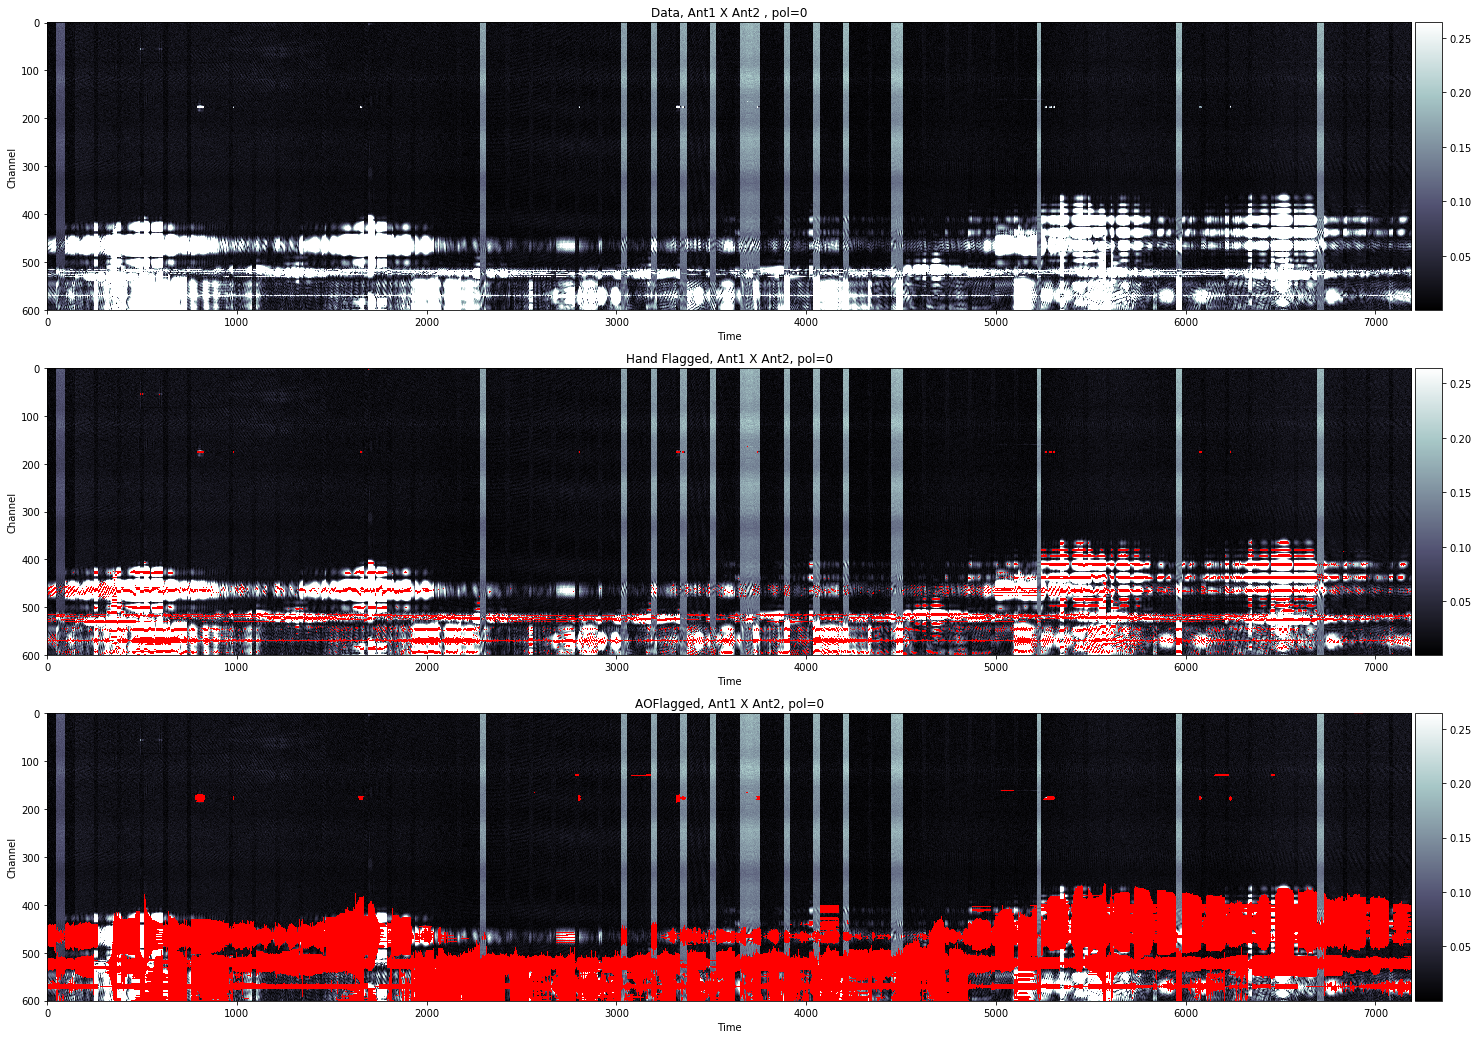

In [48]:
# extract data from desired baseline and poln for plotting:
#    data[(A1==ant1) & (A2==ant2)]                 --> selects data where A1 == ant1 and A2 == ant2
#    data[(A1==ant1) & (A2==ant2)][:,:,poln]       --> slices out all times, all channels, polarisation poln
#    abs(data[(A1==ant1) & (A2==ant2)][:,:,poln])  --> takes absolute value of complex data for plotting    
# plot baseline 1-2, polarisation 0

ant1 = 1
ant2 = 2
poln = 0

data_hand,flag_hand, stat = ms_hand.get_masked_data(ant1, ant2, poln=poln)
data_aof,flag_aof, stat = ms_aoflag.get_masked_data(ant1, ant2, poln=poln)

# put data and different flag arrays in a dictionary
# dictionary keys will be used at titles in the plot
d, hf, aof = read_casa_table.get_title(poln,ant1,ant2)

#create dict
av_arr = {d:data_hand[poln], hf:flag_hand[poln], aof:flag_aof[poln]}

#plot
_ = read_casa_table.plot_rfi_data_dict(av_arr, stat, order=[d,hf,aof])

### Analyse the time-frequency averaged MS file: filename_av.ms

In [ ]:
ms_av_hand = read_casa_table(MSfile_av,verbose=1)
ms_av_aoflag = read_casa_table(MSfileFlagged_av,verbose=1)

### Show Time-Frequency plot

In [10]:
ant1 = 2
ant2 = 3
poln = 0

data_av_hand,flag_av_hand, stat_av = ms_av_hand.get_masked_data(ant1, ant2, poln=poln)
data_av_aof,flag_av_aof, stat_av = ms_av_aoflag.get_masked_data(ant1, ant2, poln=poln)

# put data and different flag arrays in a dictionary
# dictionary keys will be used at titles in the plot
d, hf, aof = read_casa_table.get_title(poln,ant1,ant2)

#create dict
av_arr = {d:data_av_hand[poln], hf:flag_av_hand[poln], aof:flag_av_aof[poln]}
#plot
_ = read_casa_table.plot_rfi_data_dict(av_arr, stat_av, order=[d,hf,aof])

Successful readonly open of default-locked table /data/data/KAT7_data/original/1354773022.full_pol_av.ms: 25 columns, 48015 rows
('Number of antennas:  ', 6)
('List of antennas:    ', [0, 1, 2, 3, 4, 5])
('Number of baselines: ', 15)
()
Successful readonly open of default-locked table /data/data/KAT7_data/aoflagged/flagged/1354773022.full_pol_av.ms: 25 columns, 48015 rows
('Number of antennas:  ', 6)
('List of antennas:    ', [0, 1, 2, 3, 4, 5])
('Number of baselines: ', 15)
()
('unmasked data.shape', (48015, 601, 4))
('Number of timestamps:    ', 48015)
('Number of channels:      ', 601)
('Number of polarisations: ', 4, '\n')
('using pol_list=', [0])
('unmasked data.shape', (48015, 601, 4))
('Number of timestamps:    ', 48015)
('Number of channels:      ', 601)
('Number of polarisations: ', 4, '\n')
('using pol_list=', [0])


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
